In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
import sys
import copy
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import geopandas as gpd
from ExKMC.Tree import Tree as ExTree
from ruleclustering import *

%load_ext autoreload
%autoreload 2

In [2]:
# NOTE: The following is important for recreating results, 
# But can be changed for randomized analysis.
seed = 342
np.random.seed(seed)

In [3]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this aside from font.size
# To get tex working on linux run the following:
# `sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super`
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6), cmap(7)]
cmap_subset = ListedColormap(subset_colors)

cmap2 = ["white", cmap(5)]
cmap2 = ListedColormap(cmap2)

### Data

In [4]:
shapefile_path = '../data/climate_divisions/climate_divisions.shp'
dtype_dict = {'CLIMDIV': 'str'}
gdf = gpd.read_file(shapefile_path, dtype = dtype_dict)
gdf['CLIMDIV'] = gdf['CLIMDIV'].apply(lambda x: f'{int(x):04d}')

/project/mcnet/kevin/explainable_clustering/venv/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver ESRI Shapefile does not support open option DTYPE
  return ogr_read(


In [5]:
climate_data = pd.read_csv('../data/climate.csv', dtype={'ID': str, 'Year': str})
climate_data.set_index(['ID', 'Year'], inplace=True)

historical_years = [str(i) for i in range(1900,2000)]
recent_years = [str(i) for i in range(2013,2024)]

historical = climate_data.loc[pd.IndexSlice[:, historical_years], :]
recent = climate_data.loc[pd.IndexSlice[:, recent_years], :]

historical_avg = historical.groupby(level='ID').mean()
recent_avg = recent.groupby(level='ID').mean()

climate_change = (recent_avg - historical_avg)/historical_avg
climate_change = climate_change.loc[gdf.CLIMDIV,:]

In [6]:
# change months to seasons\n",
groupings = {'pcpn_winter': ['pcpn_dec', 'pcpn_jan', 'pcpn_feb'],
            'pcpn_spring': ['pcpn_mar', 'pcpn_apr', 'pcpn_may'],
            'pcpn_summer': ['pcpn_june', 'pcpn_july', 'pcpn_aug'],
            'pcpn_fall': ['pcpn_sept', 'pcpn_oct', 'pcpn_nov'],
            'temp_winter': ['temp_dec', 'temp_jan', 'temp_feb'],
            'temp_spring': ['temp_mar', 'temp_apr', 'temp_may'],
            'temp_summer': ['temp_june', 'temp_july', 'temp_aug'],
            'temp_fall': ['temp_sept', 'temp_oct', 'temp_nov']}

seasonal_historical = pd.DataFrame()
seasonal_recent = pd.DataFrame()
seasonal_climate_change = pd.DataFrame()

# Calculate the average for each group of months
for group_name, columns in groupings.items():
    seasonal_historical[group_name] = historical_avg[columns].mean(axis=1)
    seasonal_recent[group_name] = recent_avg[columns].mean(axis=1)
    seasonal_climate_change[group_name] = climate_change[columns].mean(axis=1)

In [7]:
data = climate_change.to_numpy()
feature_labels = climate_change.columns

scaler = MinMaxScaler()
data = scaler.fit_transform(data)

### KMeans

In [8]:
k = 7
kmeans = KMeans(n_clusters=k, n_init="auto").fit(data)
kmeans_assignment = labels_to_assignment(kmeans.labels_)
cost = kmeans_cost(data, kmeans_assignment, kmeans.cluster_centers_, normalize = True)

In [9]:
cost

0.013150172344118163

([], [])

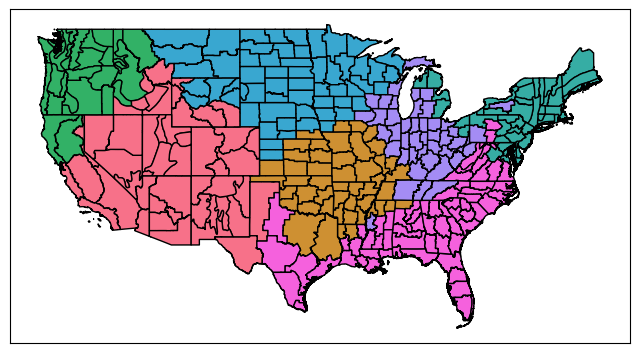

In [10]:
label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = kmeans.labels_[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8))
gdf.plot(column='cluster', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper left', bbox_to_anchor=(-0.2, 1), borderaxespad=0.)
 
plt.xticks([])
plt.yticks([]) 
#plt.savefig('../figures/decision_sets/kmeans.png', bbox_inches = 'tight', dpi = 300)

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
single_cluster = 3
single_cluster_labels = (kmeans.labels_ == single_cluster).astype(int)
clf = DecisionTreeClassifier(max_depth = 2, random_state=0)
clf.fit(data, single_cluster_labels)

DecisionTreeClassifier(max_depth=2, random_state=0)

In [53]:
clf.tree_.children_right

array([ 4,  3, -1, -1,  6, -1, -1], dtype=int64)

[Text(0.5, 0.8333333333333334, 'x[21] <= 0.76\ngini = 0.244\nsamples = 344\nvalue = [295, 49]'),
 Text(0.25, 0.5, 'x[13] <= 0.665\ngini = 0.02\nsamples = 296\nvalue = [293, 3]'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.007\nsamples = 294\nvalue = [293, 1]'),
 Text(0.375, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [0, 2]'),
 Text(0.75, 0.5, 'x[13] <= 0.549\ngini = 0.08\nsamples = 48\nvalue = [2, 46]'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(0.875, 0.16666666666666666, 'gini = 0.0\nsamples = 46\nvalue = [0, 46]')]

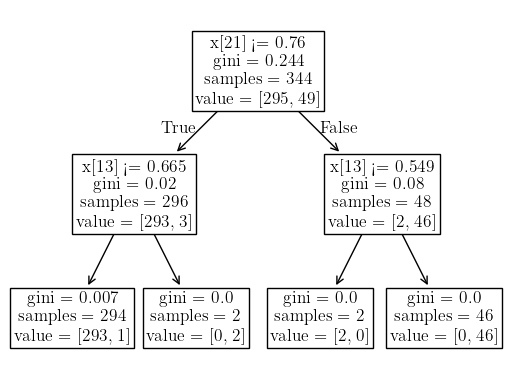

In [17]:
plot_tree(clf)

In [35]:
skTree = SklearnTree(
    data_labels = kmeans.labels_,
    max_depth = 3,
    min_points_leaf = 1,
    feature_labels = feature_labels
)
skTree.fit(data)

In [36]:
skTree.SklearnT.get_n_leaves()

6

In [109]:
rules = forest
rule_kmeans = KMeansRuleClustering(
    skTree,
    k_clusters = k,
    init = 'manual',
    center_init = kmeans.cluster_centers_,
    random_seed = seed
)
rule_kmeans.fit(data, fit_rules = False)

### Decision Forest

Build a random forest as a collection of centroid trees on randomly chosen subsets of features. 

Let $p$ denote the maximum depth we allow tree to take.

* For every tree choose depth as $\mathrm{uniform}([1,2,...,p])$

Let $F_1,...,F_{\ell}$ denote feature subsets which are allowed to be used together in a tree. Let $w$ denote the maximum number of features used for each tree.

* For every tree randomly choose a subset of features $F_i$ as $\mathrm{uniform}([F_1,F_2,...,F_{\ell}])$

* Choose the number of features to use from $\mathrm{uniform}([1,2,...,\min\{w, |F_i|\}])$

* Uniformly choose these features from $F_i$

Once we have a depth and a subset of features, $F_i$, we may then train a centroid tree on the subset of data corresponding to the chosen features $X[:,F_i]$. 

This is then done over a series of $s$ samples.

In [17]:
seed

342

In [76]:
feature_pairings = [list(range(12))] + [list(range(12,24))]

'''
forest_tree_params = {
    'splits' : 'axis',
    'max_leaf_nodes' : 2*k,
    'max_depth' : 2,
    'norm' : 2,
    'center_init' : 'k-means',
    'n_centers' : k,
    'random_seed' : seed
}
'''
forest_tree_params = {
    'data_labels' : kmeans.labels_,
    'max_depth' : 3
}

forest = DecisionForest(
    SklearnTree,
    tree_params = forest_tree_params, 
    num_trees = 1000,
    max_features = 6,
    feature_pairings = feature_pairings, 
    train_size = 0.75,
    #random_seed = seed,
    feature_labels = feature_labels
)

forest.fit(data)

In [77]:
len(forest.decision_set)

2009

### Complete Clustering

Once we have a forest we can cluster all of its leaves to produce a complete picture of what the forest looks like in aggregation.

In [78]:
rules = forest
rule_kmeans = KMeansRuleClustering(
    rules,
    k_clusters = k,
    init = 'manual',
    center_init = kmeans.cluster_centers_,
    random_seed = seed
)
rule_kmeans.fit(data, fit_rules = False)

In [79]:
model = rule_kmeans
rule_labels = assignment_to_labels(model.rule_assignment)
data_assignment = model.predict(data, assignment_method = 'min')
data_labels = assignment_to_labels(data_assignment)
#data_labels = [np.nan if _ == [] else _ for _ in data_labels]

In [80]:
kmeans_cost(data, data_assignment, rule_kmeans.centers, normalize = True)

0.01343498265070262

In [81]:
# INCLUDE A voted or minimal assignment here just for visualization??

([], [])

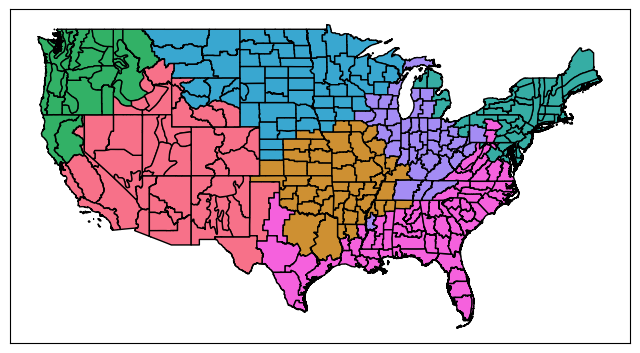

In [82]:
flattened_data_labels = flatten_labels(data_labels)
if len(flattened_data_labels) != len(data_labels):
    raise ValueError('Assumes data points have a single cluster label.')

label_array = np.empty(len(gdf))
label_array[:] = np.nan
for i,id in enumerate(climate_change.index):
    idx = gdf.loc[gdf.CLIMDIV == id].index
    if len(idx) == 1:
        label_array[idx[0]] = flattened_data_labels[i]

gdf['cluster'] = label_array

fig,ax = plt.subplots(figsize=(8,8), dpi = 100)
#gdf.plot(column='cluster', cmap=cmap_subset2, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
gdf.plot(column='cluster', cmap=cmap_subset, ax = ax, legend=False, edgecolor = 'black', alpha = 1)

#legend_labels = np.unique(label_array)
#cmap = plt.get_cmap('tab20')
#norm = mcolors.Normalize(vmin=np.min(legend_labels), vmax=np.max(legend_labels))
#patches = [mpatches.Patch(color=cmap(norm(value)), label=f'cluster {int(value)}') for value in legend_labels]
#plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1), borderaxespad=0.)
plt.xticks([])
plt.yticks([]) 
#plt.savefig('figures/climate7/centroid_oblique_clustering.png', bbox_inches = 'tight', dpi = 300)
#plt.savefig('../figures/decision_sets/voted_cluster.png', bbox_inches = 'tight', dpi = 300)

### Pruning with coverage and cost

Again let 

$$g(S) = \sum_{i = 1}^k \left| \bigcup_{R \in S, R \rightarrow c_i} X_R \cap X_{c_i}\right|$$

Now, we also want to ensure that the rules we select for a cluster have minimal overlap with data points from other clusters. 

To do so consider the following cost objective.

$$c(S) = \sum_{i = 1}^k \sum_{R \in S, R \rightarrow c_i} \left|X_R \cap (X \setminus X_{c_i})\right|$$

Where the idea is to sum over rules instead of taking their union in order to find the total number of times our rules cover points outside of their own cluster. 

Now we may consider the objective 

$$f(S) = g(S) - \lambda c(S)$$

and search for solutions with a distorted greedy approach.

In [89]:
q = 14
search_range = np.linspace(0,10,100)
coverage_threshold = 0.9 * len(data)

def clustering_objective(S):
    A = rule_kmeans.points_to_rules[:, S]
    B = rule_kmeans.rule_assignment[S, :]
    pruned_assignment = np.dot(A,B)
    return kmeans_cost(data, pruned_assignment, rule_kmeans.centers, normalize = True)

In [90]:
#data_labels = assignment_to_labels(kmeans_assignment)

In [91]:
selected_rules = prune_with_grid_search(
    q,
    data_labels,
    rule_labels,
    forest.covers,
    clustering_objective,
    search_range,
    coverage_threshold
)
selected_rule_labels = [rule_labels[r] for r in selected_rules]
pruned_forest = [forest.decision_set[r] for r in selected_rules]

print('Clustering Objective value: ' + str(clustering_objective(selected_rules)))

Clustering Objective value: 0.013260288746769615


In [92]:
rule_covers = forest.get_covers(data)
covered_points = set()
for r in selected_rules:
    covered_points = covered_points.union(rule_covers[r])

print(len(covered_points))

313


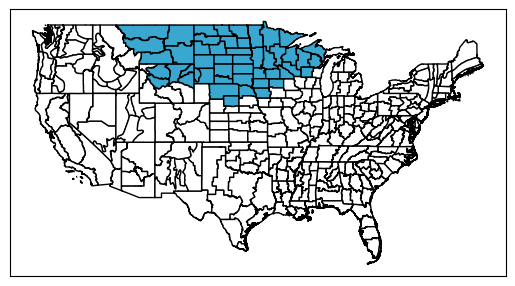

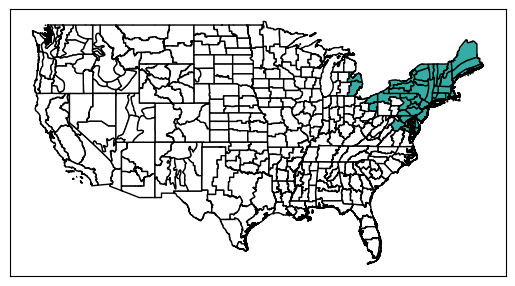

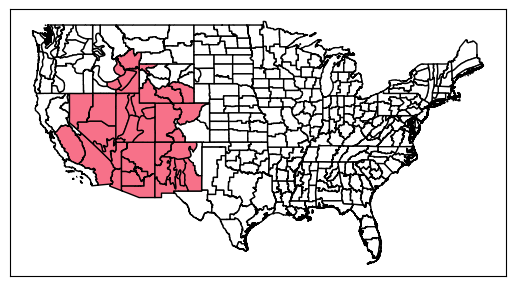

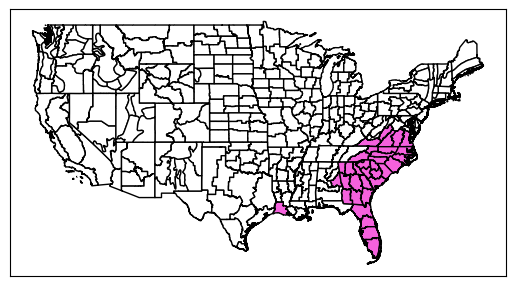

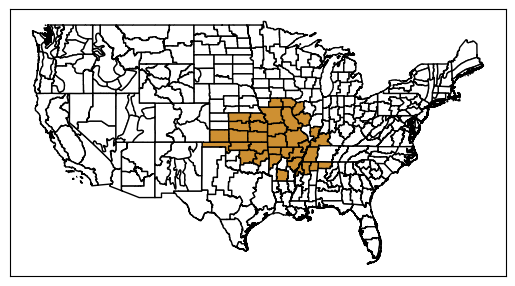

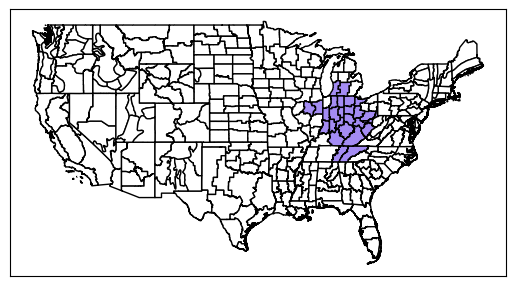

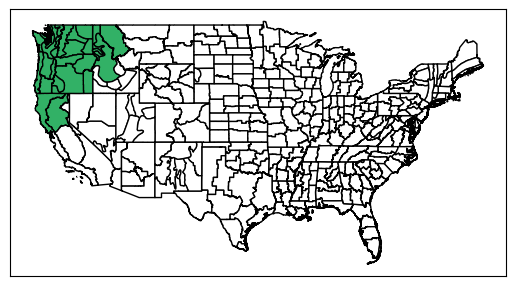

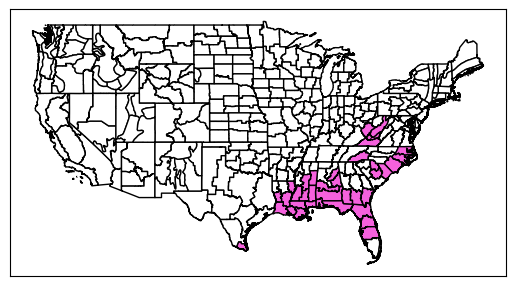

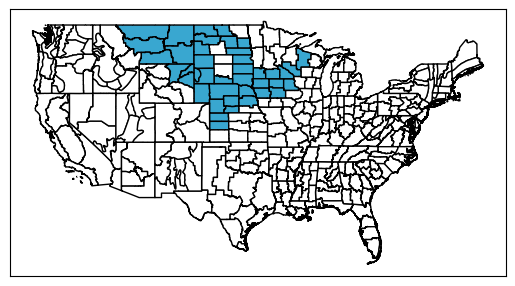

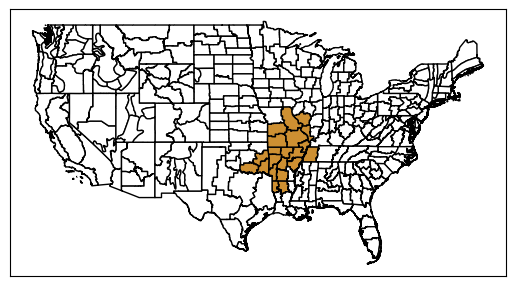

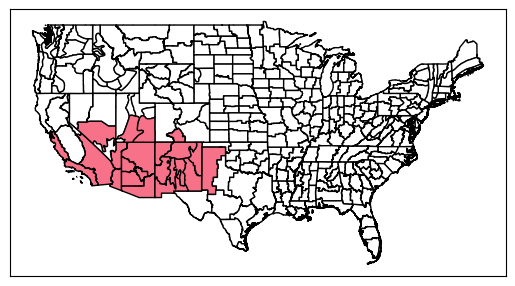

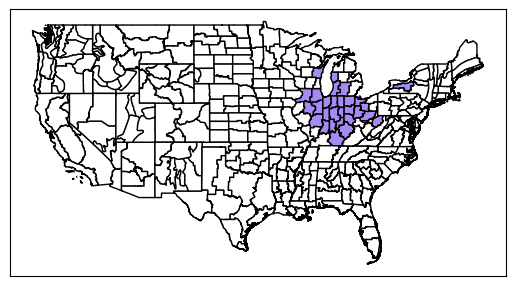

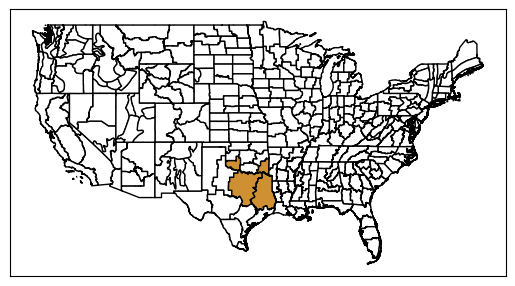

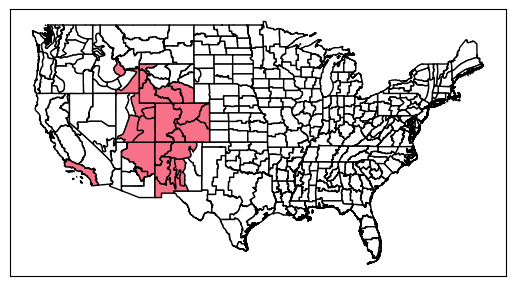

In [93]:
#fig,ax = plt.subplots(q, 1, figsize = (8,8*q), dpi = 100)

for r in range(q):
    r_labels = np.zeros(len(data)) - 1
    r_labels[rule_covers[selected_rules[r]]] = r
    
    label_array = np.empty(len(gdf))
    label_array[:] = np.nan
    for i,ide in enumerate(climate_change.index):
        idx = gdf.loc[gdf.CLIMDIV == ide].index
        if len(idx) == 1:
            label_array[idx[0]] = r_labels[i]

    fig,ax = plt.subplots(dpi = 100)
    c = selected_rule_labels[r]
    new_cmap = ["white", cmap_subset(c)]
    new_cmap = ListedColormap(new_cmap)
    gdf['cluster'] = label_array
    gdf.plot(column='cluster', cmap=new_cmap, ax = ax, legend=False, edgecolor = 'black', alpha = 1)
    plt.xticks([])
    plt.yticks([]) 
    #plt.savefig('../figures/decision_sets/rule_' + str(r) + '.png', bbox_inches = 'tight', dpi = 300)

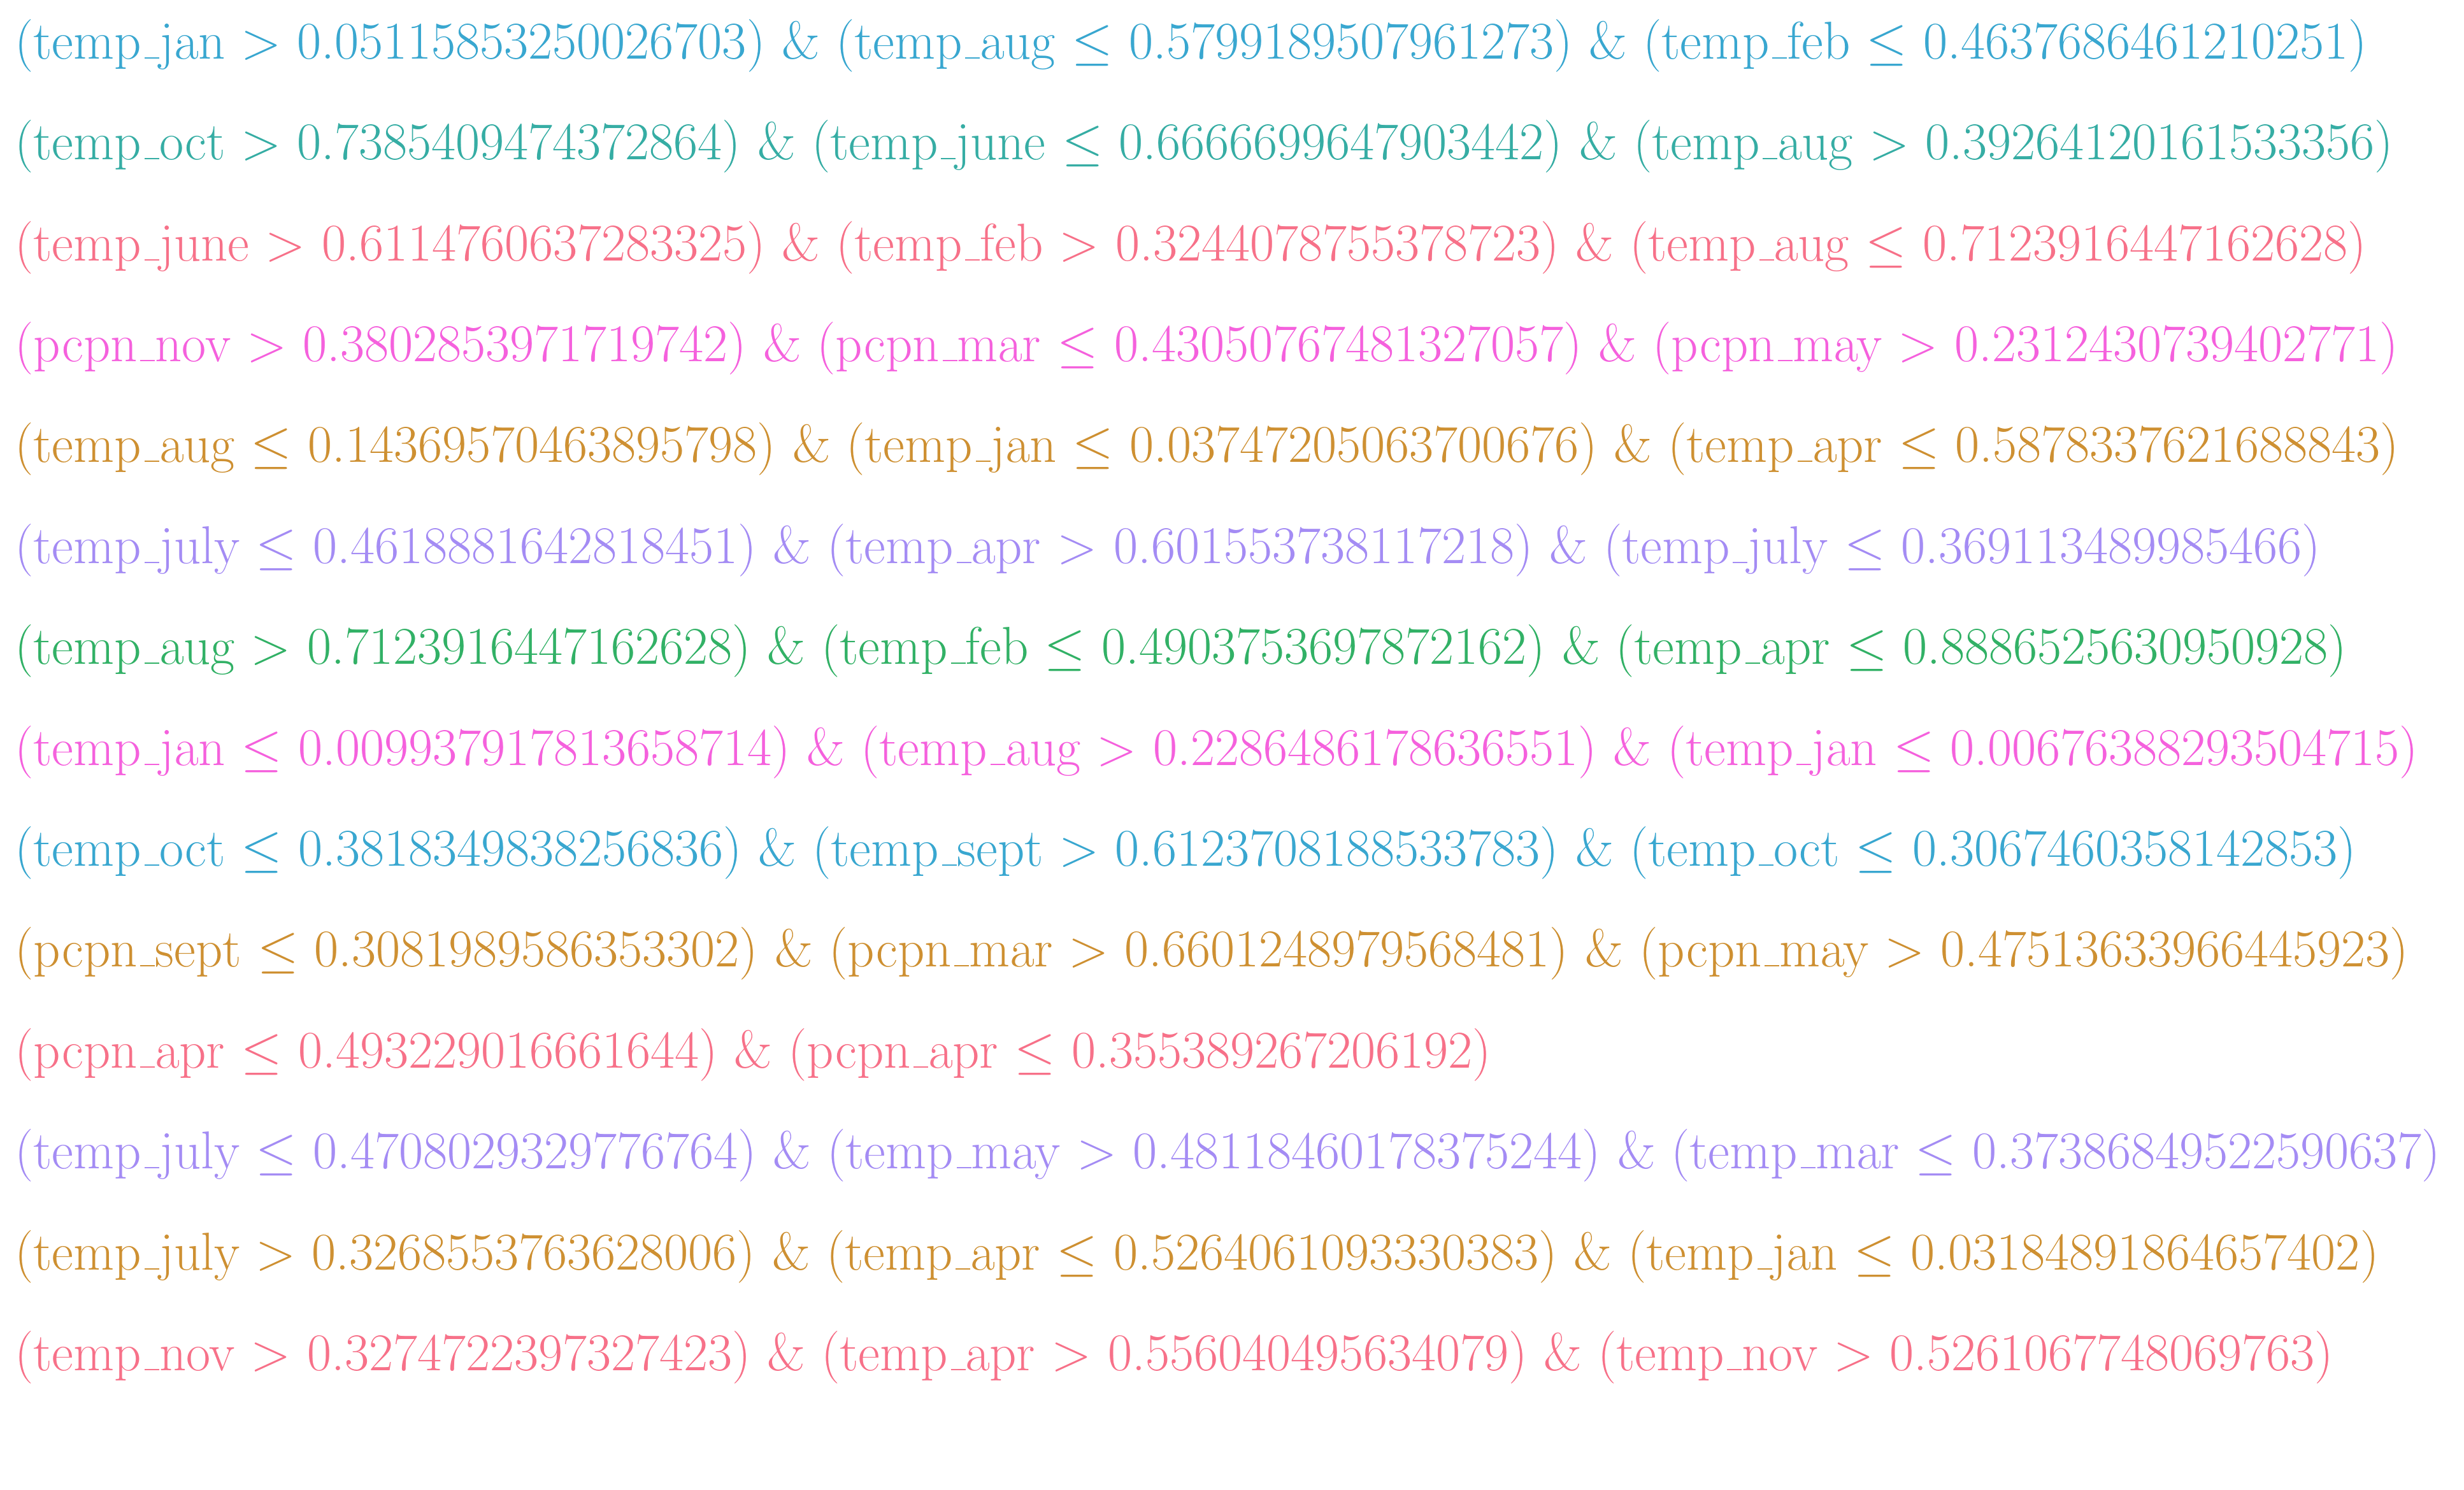

In [94]:
#fname = '../figures/decision_sets/rule_list.png'
fname = None
cluster_colors = {i: cmap_subset(i) for i in range(k)}
plot_decision_set(pruned_forest, feature_labels, flatten_labels(selected_rule_labels), cluster_colors, filename = fname)

In [95]:
np.log2(14)

3.807354922057604

### A more general problem

Suppose we have a subset of rules $S \subseteq \mathcal{R}$.

Recall that since our rules are leaf nodes, they may be described as conjunctions

$$R(x) = r_1(x) \wedge r_2(x) \wedge \ldots \wedge r_{v}(x)$$.

A subset $S$ of rules may then be described as a logical union of conjuctions in DNF form:

$$S(x) = R_1(x) \vee R_2(x) \vee \ldots \vee R_{\ell}(x)$$

In other words, $S$ may be described as a large rule itself.

We say that a DNF rule $S$ *covers* a subset of points $A \subseteq X$ if 

$$A \subseteq \bigcup_{x \in X, S(x) = \mathrm{True}} x$$

#### Problem:
Use $S$ to find a minimally sized rule $S'$ in DNF form which covers all points in $A$.

#### First Idea:
Since $S$ covers $A$, every point $x \in A$ must be satisfied by at least one rule $R_i \in S$. 

Each rule $R_i \in S$,
may then be associated with a set $P_i = X_{R_i} \cap A$.

And we may select a subset of rules $S'$ using a set cover framework.

### Experiments

In [218]:
# REMINDER: The seed should only be given to the experiment object which 
# initializes the seed at the beginning of the experiment. It should NOT 
# within the parameters of any sub-function or class, since these will 
# reset the seed each time they are given one. 
seed

342

In [264]:
# Parameters:
seed = seed
n_clusters = k
min_rules = k
max_rules = 2*k
min_depth = 3
max_depth = 6

# Base module
base = KMeansBase(n_clusters)
A,C = base.assign(data)

cluster_model = KMeansRuleClustering
cluster_params = {
    'k_clusters' : n_clusters,
    'init' : 'manual',
    'center_init' : C,
    'max_iterations' : 500,
}

# Modules:

# Tree:
tree_params = {
    'splits' : 'axis',
    'max_leaf_nodes' : max_rules,
    'max_depth' : max_depth,
    'norm' : 2,
    'center_init' : 'k-means',
    'n_centers' : n_clusters
}

mod1 = TreeMod(
    tree_model = CentroidTree,
    tree_params = tree_params,
    cluster_model = cluster_model,
    cluster_params = cluster_params,
    min_rules = min_rules,
    min_depth = min_depth,
    name = 'Centroid'
)


# Forest:
forest_params = {
    'tree_model' : CentroidTree,
    'tree_params' : tree_params,
    'num_trees' : 100,
    'max_features' : 9,
    'feature_pairings' : [list(range(12))] + [list(range(12,24))],
    'train_size' : 0.75
}

prune_params = {
    'search_range' : np.linspace(0,1,100),
    'coverage_threshold' : 0.9 * len(data)
}

mod2 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params,
    cluster_model = cluster_model,
    cluster_params = cluster_params,
    assignment_method = 'vote',
    prune_params = None,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Vote'
)

mod3 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params,
    cluster_model = cluster_model,
    cluster_params = cluster_params,
    assignment_method = 'vote',
    prune_params = prune_params,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Vote-Pruned'
)

mod4 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params,
    cluster_model = cluster_model,
    cluster_params = cluster_params,
    assignment_method = 'min',
    prune_params = None,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Min'
)

mod5 = ForestMod(
    forest_model = DecisionForest,
    forest_params = forest_params,
    cluster_model = cluster_model,
    cluster_params = cluster_params,
    assignment_method = 'min',
    prune_params = prune_params,
    min_rules = min_rules,
    min_depth = min_depth,
    max_rules = max_rules,
    max_depth = max_depth,
    name = 'Forest-Min-Pruned'
)


baseline_list = [base]
module_list = [mod1, mod2, mod3, mod4, mod5]

In [265]:
cost_fns = {
    'standard' : kmeans_cost,
    'normalized' : kmeans_cost,
    'normalized_v2' : kmeans_cost
}

cost_fn_params = {
    'standard' : {},
    'normalized' : {'normalize' : True},
    'normalized_v2' : {'normalize' : True, 'square' : 'True'}
}

Ex1 = RulesExperiment(
    data = data,
    baseline_list = baseline_list,
    module_list = module_list,
    cost_fns = cost_fns,
    cost_fn_params = cost_fn_params,
    random_seed = seed,
    verbose = True
)

Ex1_results = Ex1.run(min_rules = min_rules, max_rules = max_rules)
#Ex1.save_results('../data/experiments/decision_sets/', '_standard')

Running for 7 rules.
Running for 8 rules.
Running for 9 rules.
Running for 10 rules.
Running for 11 rules.
Running for 12 rules.
Running for 13 rules.
Running for 14 rules.


In [ ]:
cost_fns = {
    'standard' : kmeans_cost,
    'normalized' : kmeans_cost,
    'normalized_v2' : kmeans_cost
}

cost_fn_params = {
    'standard' : {},
    'normalized' : {'normalize' : True},
    'normalized_v2' : {'normalize' : True, 'square' : 'True'}
}

Ex2 = DepthExperiment(
    data = data,
    baseline_list = baseline_list,
    module_list = module_list,
    cost_fns = cost_fns,
    cost_fn_params = cost_fn_params,
    random_seed = seed,
    verbose = True
)

Ex2_results = Ex2.run(min_depth = min_depth, max_depth = max_depth)

### Plotting Results

In [104]:

directory = '../data/experiments/decision_sets/'

rules_cost_filename = os.path.join(directory, 'rules_cost_climate_sklearn_d2.csv')
depth_cost_filename = os.path.join(directory, 'depth_cost_climate.csv')

rules_cost = pd.read_csv(rules_cost_filename, index_col = 0, header = [0,1])
depth_cost = pd.read_csv(depth_cost_filename, index_col = 0, header = [0,1])

rules_cost_standard = rules_cost['standard']
rules_cost_normalized = rules_cost['normalized']
rules_cost_normalized_v2 = rules_cost['normalized_v2']

depth_cost_standard = depth_cost['standard']
depth_cost_normalized = depth_cost['normalized']
depth_cost_normalized_v2 = depth_cost['normalized_v2']

In [105]:
rules_cost

standard                                                         \
       KMeans    Centroid Forest-Vote Forest-Vote-Pruned  Forest-Min   
0  105.497861  133.909283  116.450815         112.883507  109.809391   
1  105.497861  131.812014  116.450815         115.663836  109.809391   
2  105.497861  121.126419  116.450815         118.571934  109.809391   
3  105.497861  118.380115  116.450815         116.131874  109.809391   
4  105.497861  118.380115  116.450815         118.954848  109.809391   
5  105.497861  116.987060  116.450815         123.709447  109.809391   
6  105.497861  116.987060  116.450815         123.581557  109.809391   
7  105.497861  116.987060  116.450815         124.838121  109.809391   

                    normalized                                           \
  Forest-Min-Pruned     KMeans  Centroid Forest-Vote Forest-Vote-Pruned   
0        117.006826   0.012778  0.016220    0.014105           0.013966   
1        118.864178   0.012778  0.015966    0.014105           0.013893   
2        119.028306   0.012778  0.014671    0.014105           0.014341   
3        116.868227   0.012778  0.014339    0.014105           0.014267   
4        115.574920   0.012778  0.014339    0.014105           0.014185   
5        117.716104   0.012778  0.014170    0.014105           0.014328   
6        119.231388   0.012778  0.014170    0.014105           0.014335   
7        119.662439   0.012778  0.014170    0.014105           0.014408   

                               normalized_v2                        \
  Forest-Min Forest-Min-Pruned        KMeans  Centroid Forest-Vote   
0   0.013301          0.013711      0.000892  0.001132    0.000984   
1   0.013301          0.013645      0.000892  0.001114    0.000984   
2   0.013301          0.013647      0.000892  0.001024    0.000984   
3   0.013301          0.013707      0.000892  0.001000    0.000984   
4   0.013301          0.013757      0.000892  0.001000    0.000984   
5   0.013301          0.013866      0.000892  0.000989    0.000984   
6   0.013301          0.013873      0.000892  0.000989    0.000984   
7   0.013301          0.013819      0.000892  0.000989    0.000984   

                                                   
  Forest-Vote-Pruned Forest-Min Forest-Min-Pruned  
0           0.001074   0.000928          0.001055  
1           0.001069   0.000928          0.001046  
2           0.001103   0.000928          0.001053  
3           0.001097   0.000928          0.001054  
4           0.001067   0.000928          0.001058  
5           0.001065   0.000928          0.001053  
6           0.001062   0.000928          0.001047  
7           0.001061   0.000928          0.001040

In [98]:
'''
rules_cost_standard = Ex1_results['standard']
rules_cost_normalized = Ex1_results['normalized']
rules_cost_normalized_v2 = Ex1_results['normalized_v2']
'''

"\nrules_cost_standard = Ex1_results['standard']\nrules_cost_normalized = Ex1_results['normalized']\nrules_cost_normalized_v2 = Ex1_results['normalized_v2']\n"

In [106]:
#0,1,3
def plotter(cost_df, xlabel, ylabel, domain, cmap):
    fig,ax = plt.subplots(figsize = (6,4))
    baseline_list = ['KMeans']
    baseline_linestyles = ['-']
    baselines = [_ for _ in cost_df.columns if _ in baseline_list]
    modules = [_ for _ in cost_df.columns if _ not in baselines]
    
    end = -1
    for i,b in enumerate(baselines):
        ax.hlines(
            cost_df[b].iloc[0],
            xmin = domain[0],
            xmax = domain[end],
            color = 'k',
            label = fr'$\texttt{{{b}}}$',
            linestyle = baseline_linestyles[i],
            linewidth = 3,
            alpha = 0.6
        )
    
    for i,m in enumerate(modules):
        ax.plot(
            domain,
            np.array(cost_df[m]),
            linewidth = 3,
            marker='o',
            markersize = 5,
            c = cmap(i),
            label = fr'$\texttt{{{m}}}$'
        )

    ticks = np.arange(domain[0], domain[end] + 1, 1) 
    labels = [str(i) for i in ticks] 
    plt.xticks(ticks, labels)

    plt.legend(loc = 'upper right', bbox_to_anchor=(2, 1))
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.show()

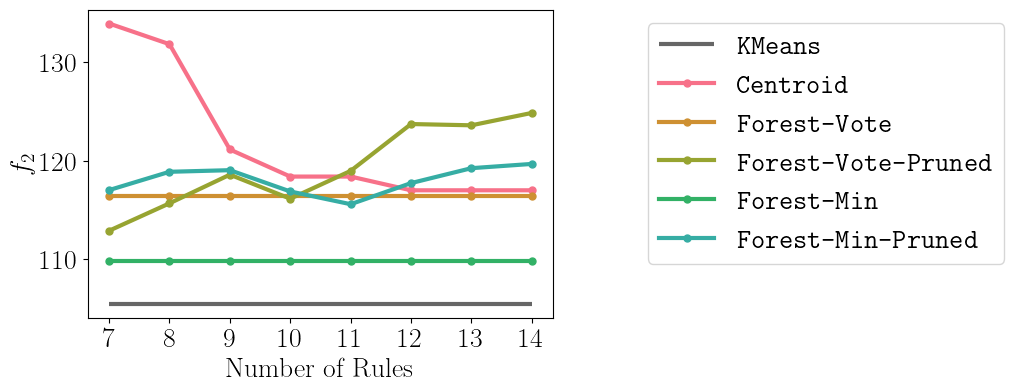

In [107]:
plotter(
    rules_cost_standard,
    xlabel = 'Number of Rules',
    ylabel = '$f_2$',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap
)

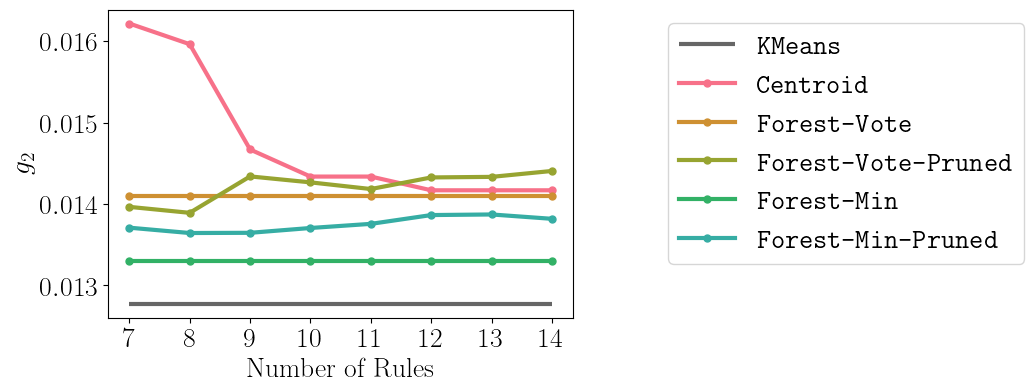

In [108]:
plotter(
    rules_cost_normalized,
    xlabel = 'Number of Rules',
    ylabel = '$g_2$',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap
)

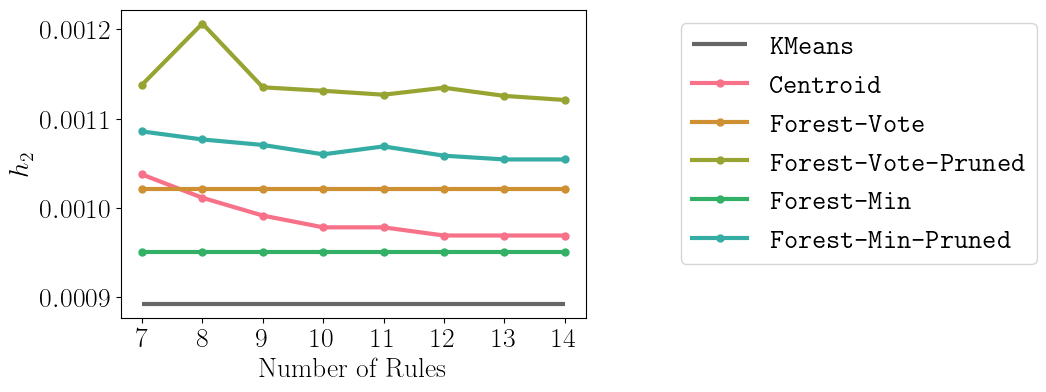

In [102]:
plotter(
    rules_cost_normalized_v2,
    xlabel = 'Number of Rules',
    ylabel = '$h_2$',
    domain = list(range(k, 2*k + 1)),
    cmap = cmap
)

In [ ]:
### plotter(
    depth_cost_standard,
    xlabel = 'Depth',
    ylabel = '$f_2$',
    domain = list(range(3, 6 + 1)),
    cmap = cmap
)

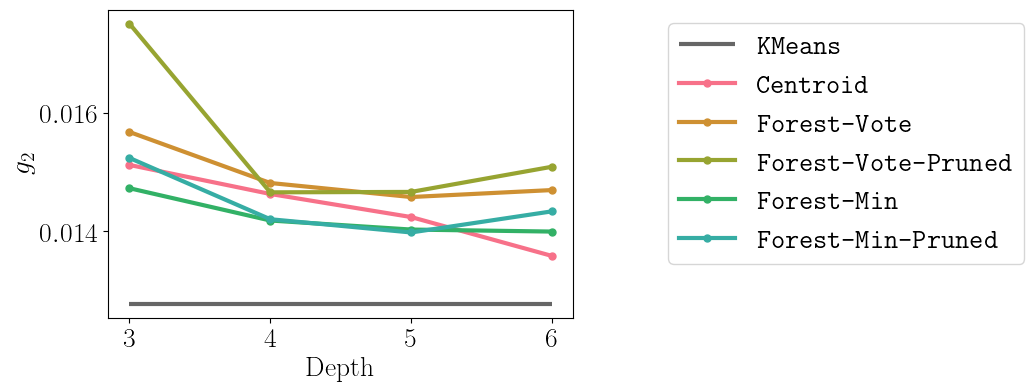

In [19]:
plotter(
    depth_cost_normalized,
    xlabel = 'Depth',
    ylabel = '$g_2$',
    domain = list(range(3, 6 + 1)),
    cmap = cmap
)

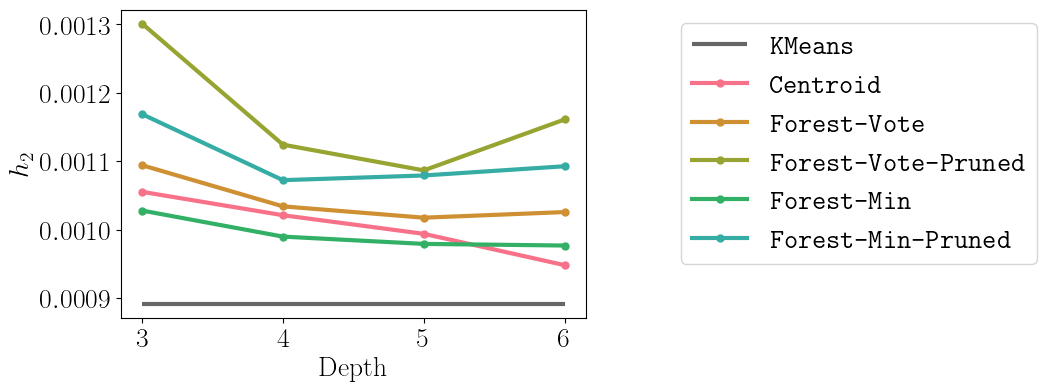

In [20]:
plotter(
    depth_cost_normalized_v2,
    xlabel = 'Depth',
    ylabel = '$h_2$',
    domain = list(range(3, 6 + 1)),
    cmap = cmap
)